## Классификация изображений
### Вводные слова
Задача классификации изображений - это одна из ключевых задач в области компьютерного зрения и машинного обучения. Она заключается в том, чтобы разработать модель, способную автоматически определить, к какому классу или категории принадлежит данное изображение. Классификация используется в следующих задачах: классификация спектрограмм музыкальных записей для выявления предпочтений конкретного пользователя, классификация изображений для автоматической идентификации людей на фотографиях, кластеризация покупок пользователя в интернет-магазине для формирования целевой рекламы, и так далее
### Рекомендации
Работу лучше выполнять в среде Google Colab, поскольку потребуется осуществлять вычисления на видеокарте. В Colab в меню нажмите на Изменить->Настройки блокнота и выберите доступный GPU. Это позволит использовать для обучения CUDA
### Цель работы и задачи
В данной работе мы разработаем модель, для предсказания класса на датасете cifar-10. Ниже будет представлена baseline модель, основываясь на которой вы можете строить свою модель для классификации
\
Задачи, которые вам нужно решить в работе:
\
Обязательные:
- Построить распределение классов в данных
- Подготовить данные и обучить baseline-модель на датасете
- Оценить качество модели
- Написать свою модель и обучить ее

Желательные:
- Подумать об архитектуре модели, быть может стоит сделать ее глубже, добавить боковые связи и т.д.
- Задуматься об аугментации
- Попробовать transfer-learning

\
\
Ваша работа будет оцениваться исходя из 2 факторов:
- контрольная метрика
- протокол исследования, которым и будет служить этот Jupyter-Notebook

\
Максимальный балл за работу - 20.
\
Удачи!

## Baseline-модель

In [2]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.functional import F

Обучать мы будем, разумеется, на cuda, поэтому, создадим переменную device, которая будет зависеть от того, доступна ли видеокарта для вычислений

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

# Функция для подсчета числа параметров
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Running on cpu


In [4]:
class Baseline(nn.Module):
    def __init__(self, num_classes=10):
        super(Baseline, self).__init__()
        # Сверточные слои
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Полносвязные слои
        self.fc1 = nn.Linear(in_features=32 * 8 * 8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
    
    def forward(self, x):
        # Прямой проход через сверточные слои
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        
        # Вытягивание в одномерный вектор
        x = x.view(x.size(0), -1)
        
        # Прямой проход через полносвязные слои
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

Загрузим данные, построим диаграммы для распределения классов и посмотрим на сами картинки

100%|██████████| 170M/170M [53:35<00:00, 53.0kB/s]   


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


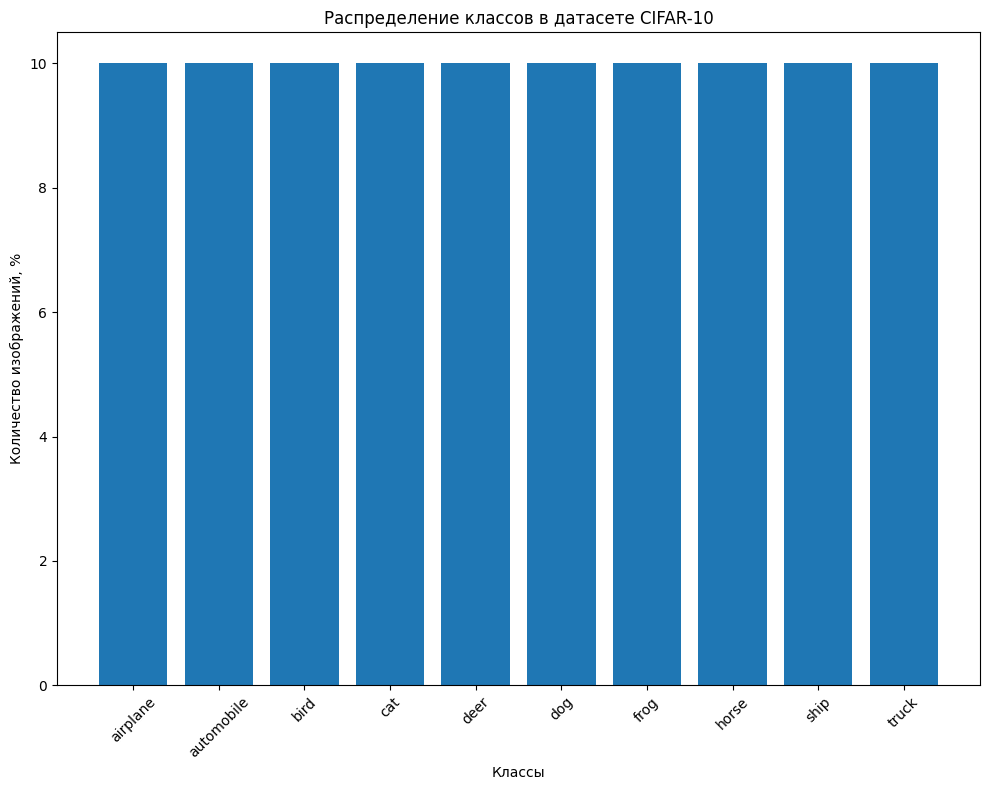

In [5]:
# Будем превращать картинку в torch.Tensor
transform = transforms.ToTensor()

# Загрузим датасеты для train и test
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Получим метки классов
class_labels = train_dataset.classes
class_counts = np.array([0] * len(class_labels))

# Посчитаем число меток классов
for _, label in train_dataset:
    class_counts[label] += 1

class_counts = class_counts / class_counts.sum() * 100

# Построим диаграмму
plt.figure(figsize=(10, 8))
plt.bar(class_labels, class_counts)
plt.xlabel('Классы')
plt.ylabel('Количество изображений, %')
plt.title('Распределение классов в датасете CIFAR-10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

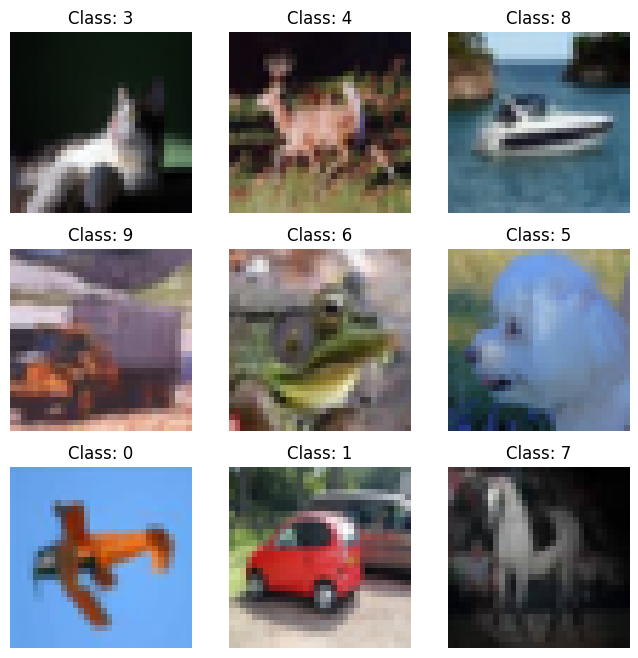

In [13]:
# Случайным образом выберите 9 индексов из обучающего набора данных без повторений
indices = np.random.choice(len(train_dataset), 9, replace=False)

# Создайте сетку 3x3 для отображения изображений
fig, axes = plt.subplots(3, 3, figsize=(8, 8))  # Укажите размеры сетки и общий размер фигуры
for i, ax in enumerate(axes.flat):
    # Извлеките изображение и метку по выбранному индексу
    image, label = train_dataset[indices[i]]
    # Преобразуйте изображение из формата (C, H, W) в формат (H, W, C), необходимый для визуализации
    image = image.numpy().transpose((1, 2, 0))
    # Отобразите изображение на текущей оси
    ax.imshow(image)
    # Установите заголовок для отображения класса
    ax.set_title(f'Class: {label}')
    # Скрыть оси для более чистого отображения
    ax.axis('off')

# Вывести изображения на экран
plt.show()


Сделайте вывод о сбалансированности датасета:
\
Исходя из этого, какие метрики будем применять для оценки качества модели?


Датасет имеет сбалансированное распределение, поэтому для оценки качества модели можно использовать такие стандартные метрики, как Accuracy и Cross-Entropy Loss.

Напишем функции train и test

In [14]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    # Перевод модели в режим обучения
    model.train()
    # Перемещение модели на заданное устройство (например, GPU)
    model = model.to(device)
    # Инициализация списков для хранения значений потерь и точности
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(epochs):
        # Инициализация счетчиков для отслеживания потерь и точности на обучающей выборке
        running_loss = 0.0
        correct = 0
        total = 0
        # Использование tqdm для визуализации процесса обучения
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100, desc='Train epoch {}/{}'.format(epoch + 1, epochs))
        for batch_idx, (inputs, labels) in pbar:
            # Перемещение данных на устройство
            inputs, labels = inputs.to(device), labels.to(device)
            # Обнуление градиентов оптимизатора
            optimizer.zero_grad()
            # Прямой проход модели
            outputs = model(inputs)
            # Вычисление потерь
            loss = criterion(outputs, labels)
            # Обратный проход (вычисление градиентов)
            loss.backward()
            # Обновление параметров модели
            optimizer.step()
            # Накопление значений потерь
            running_loss += loss.item()
            # Подсчет точности предсказаний
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Обновление визуализации процесса обучения
            pbar.set_postfix({'loss': '{:.4f}'.format(running_loss / (batch_idx + 1)), 'accuracy': '{:.4f}'.format(correct / total)})
        # Сохранение результатов по потерям и точности для обучающей выборки
        train_loss_history.append(running_loss / len(train_loader))
        train_acc_history.append(correct / total)
        # Инициализация счетчиков для валидационной выборки
        correct = 0
        total = 0
        test_loss = 0.0
        # Использование tqdm для визуализации процесса валидации
        pbar = tqdm(enumerate(val_loader), total=len(val_loader), ncols=100, desc='Val {}/{}'.format(epoch + 1, epochs))
        with torch.no_grad():
            for batch_idx, (inputs, labels) in pbar:
                # Перемещение данных на устройство
                inputs, labels = inputs.to(device), labels.to(device)
                # Прямой проход модели
                outputs = model(inputs)
                # Вычисление потерь
                loss = criterion(outputs, labels)
                # Накопление значений потерь
                test_loss += loss.item()
                # Подсчет точности предсказаний
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                # Обновление визуализации процесса валидации
                pbar.set_postfix({'loss': '{:.4f}'.format(test_loss / (batch_idx + 1)), 'accuracy': '{:.4f}'.format(correct / total)})
        # Сохранение результатов по потерям и точности для валидационной выборки
        val_loss_history.append(test_loss / len(val_loader))
        val_acc_history.append(correct / total)
    # Возврат истории потерь и точности для анализа
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def test(model, test_loader, criterion, device):
    # Перевод модели в режим оценки
    model.eval()
    # Инициализация счетчиков для потерь и точности
    correct = 0
    total = 0
    test_loss = 0.0
    # Отключение вычисления градиентов
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Перемещение данных на устройство
            inputs, labels = inputs.to(device), labels.to(device)
            # Прямой проход модели
            outputs = model(inputs)
            # Вычисление потерь
            loss = criterion(outputs, labels)
            # Накопление значений потерь
            test_loss += loss.item()
            # Подсчет точности предсказаний
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Вычисление средней точности и потерь на тестовой выборке
    accuracy = correct / total
    average_loss = test_loss / len(test_loader)
    # Возврат точности и потерь
    return accuracy, average_loss


Сделайте разделение на train и val
\
Зачем так делать?

Обучающая выборка применяется для тренировки модели, позволяя ей выявлять закономерности и зависимости в данных. Валидационная выборка служит для оценки качества модели на новых, ранее не использованных данных, что помогает предотвратить переобучение и оптимизировать гиперпараметры.

In [12]:
# Определите размер обучающей выборки как 90% от общего количества данных
train_size = int(0.9 * len(train_dataset))

# Определите размер валидационной выборки как оставшиеся 10% данных
val_size = len(train_dataset) - train_size

# Разделите набор данных на обучающую и валидационную выборки
# Укажите параметр random_state для воспроизводимости и включите перемешивание данных
train_dataset, val_dataset = train_test_split(train_dataset, test_size=val_size, random_state=42, shuffle=True)


Создайте Dataloader'ы и настройте гиперпараметры, оптимизатор и функцию потерь
\
Какой оптимизатор будете использовать и почему, а какую loss-функцию?

В качестве оптимизатора я выберу Adam, так как он эффективно справляется с регуляризацией, что снижает риск переобучения. Функцию потерь использую CrossEntropyLoss, так как она идеально подходит для задач многоклассовой классификации.

In [29]:
# Гиперпараметры
learning_rate = 0.0005  # Обычно для большинства задач с нейронными сетями начинается с такого значения
num_epochs = 60  # Количество эпох для тренировки. Может быть увеличено в зависимости от задачи и результатов
batch_size = 512  # Размер батча (обычно выбирается в зависимости от доступной памяти)

# Создание модели
model = Baseline()

print('Model params: ', count_parameters(model))

# Определяем функцию потерь и оптимизатор
criterion = torch.nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации (например, CIFAR-10)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Оптимизатор Adam, часто используется для обучения нейронных сетей

# Создание загрузчиков данных для тренировки, валидации и тестирования
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Model params:  268650


Обучите модель и постройте графики обучения

In [30]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=num_epochs)

Val 60/60: 100%|████████████████████████| 9/9 [00:00<00:00,  9.12it/s, loss=0.9825, accuracy=0.6664]


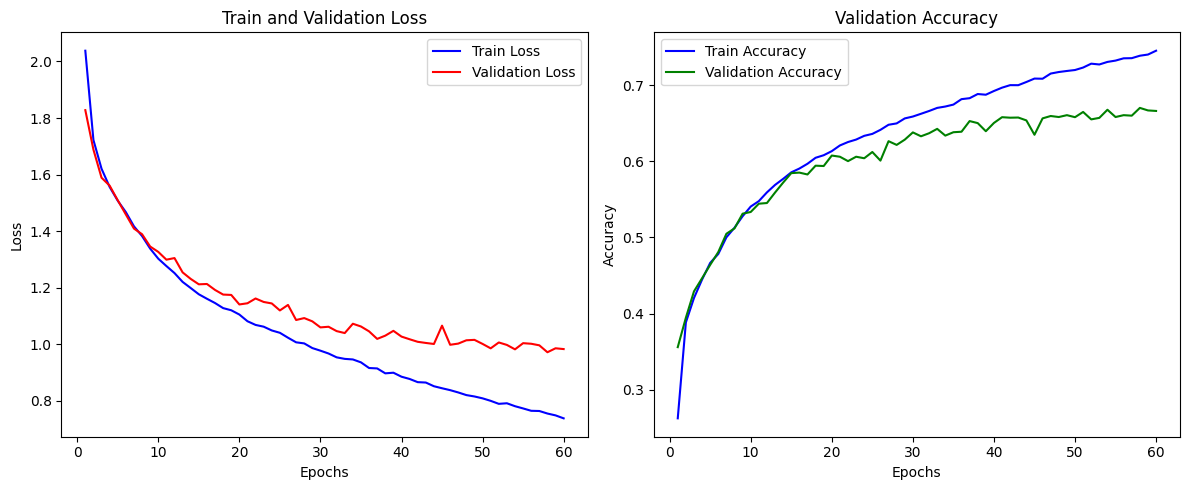

In [31]:
epochs = range(1, len(train_loss_history) + 1)

# График функции потерь на тренировочных данных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b', label='Train Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности на валидационных данных
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc_history, 'g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Сделайте выводы о качестве обучения

Модель демонстрирует положительную динамику обучения: кривые потерь и точности изменяются в правильном направлении. Стабилизация валидационной точности указывает на то, что модель достигла своего предельного потенциала для данного набора данных.

Оцените тестовую метрику на тестовых данных

In [32]:
test_acc, test_loss = test(model, test_loader, criterion, device)
print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))

Test Loss: 0.9807
Test Accuracy: 0.6649


## Что дальше?
Теперь, когда у вас есть все необходимое - экспериментируйте. Можете изменить все что угодно, креативность поощряется. Используйте новые модели, loss-функции, аугментацию, ансамбли, выдумывайте все, что сможете

## Критерии оценки
Accuracy - на тестовых данных
- $Accuracy \leq 0.67$ - 0 баллов
- $0.67 < Accuracy \leq 0.72$ - 2 балла
- $0.72 < Accuracy \leq 0.77$ - 4 балла
- $0.77 < Accuracy \leq 0.82$ - 6 баллов
- $0.82 < Accuracy \leq 0.87$ - 8 баллов
- $Accuracy > 0.87$ - 10 баллов